In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'

In [10]:
freelisting_df = pd.read_csv("data/freelisting.csv")
metadata_df = pd.read_csv("data/metadata.csv")
pile_sorting_df = pd.read_csv("data/pile_sorting.csv")

In [13]:
def calculate_salience_index(freelisting_df):
    """
    Calculate salience index for free listing items.
    Salience = (Frequency / n_respondents) / Mean_Rank

    Higher salience = more people mentioned it early
    """

    all_items = []
    item_ranks = defaultdict(list)

    for idx, row in freelisting_df.iterrows():
        items = [row['item_1'], row['item_2'], row['item_3']]
        for rank, item in enumerate(items, 1):
            all_items.append(item)
            item_ranks[item].append(rank)

    # Calculate frequency and mean rank
    item_frequency = Counter(all_items)

    salience_data = []
    for item, frequency in item_frequency.items():
        ranks = item_ranks[item]
        mean_rank = np.mean(ranks)
        salience = (frequency / len(freelisting_df)) / mean_rank

        salience_data.append({
            'item': item,
            'frequency': frequency,
            'mean_rank': mean_rank,
            'salience': salience
        })

    return pd.DataFrame(salience_data).sort_values('salience', ascending=False)


In [22]:
salience_df = calculate_salience_index(freelisting_df)

In [15]:
def build_cooccurrence_matrix(pile_sorting_df, freelisting_df):
    """
    Build co-occurrence matrix showing how often item pairs appear together in piles.
    Co-occurrence[i,j] = number of respondents who put items i and j in same pile
    """

    # Get all unique items
    all_unique_items = set()
    for items_str in pile_sorting_df['items']:
        all_unique_items.update([item.strip() for item in items_str.split(';')])

    all_unique_items = sorted(list(all_unique_items))
    n_items = len(all_unique_items)

    # Build co-occurrence matrix
    co_occurrence = np.zeros((n_items, n_items))

    for idx_i, item_i in enumerate(all_unique_items):
        for idx_j, item_j in enumerate(all_unique_items):
            if idx_i == idx_j:
                co_occurrence[idx_i, idx_j] = len(freelisting_df)  # Perfect self-cooccurrence
            else:
                # Count how many respondents put items together
                together_count = 0
                for resp_id in freelisting_df['respondent_id'].unique():
                    resp_piles = pile_sorting_df[pile_sorting_df['respondent_id'] == resp_id]

                    for _, pile_row in resp_piles.iterrows():
                        items_in_pile = [item.strip() for item in pile_row['items'].split(';')]
                        if item_i in items_in_pile and item_j in items_in_pile:
                            together_count += 1
                            break

                co_occurrence[idx_i, idx_j] = together_count

    # Normalize to similarity matrix (0-1 scale)
    similarity_matrix = co_occurrence / len(freelisting_df)

    return pd.DataFrame(similarity_matrix, 
                       index=all_unique_items,
                       columns=all_unique_items), all_unique_items

In [16]:
similarity_df, all_items = build_cooccurrence_matrix(pile_sorting_df, freelisting_df)

In [17]:
similarity_df.head()

,DNA risk,allergy,authoritarianism,biology,biotechnology,coercion,community protection,corruption,danger,distrust,...,profit,protect vulnerable,protection from disease,risk,safety,scientific progress,side effects,state control,unknown,unknown risks
DNA risk,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
allergy,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
authoritarianism,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
biology,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
biotechnology,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
all_items

['DNA risk',
 'allergy',
 'authoritarianism',
 'biology',
 'biotechnology',
 'coercion',
 'community protection',
 'corruption',
 'danger',
 'distrust',
 'economic interests',
 'fever',
 'financial interests',
 'headache',
 'health',
 'herd immunity',
 'immune system',
 'immunity',
 'life saving',
 'lobbying',
 'long-term effects',
 'mandate',
 'monopoly',
 'natural immunity',
 'naturalness',
 'nature',
 'new technology',
 'oppression',
 'past infection',
 'pharma companies',
 'prevention',
 'profit',
 'protect vulnerable',
 'protection from disease',
 'risk',
 'safety',
 'scientific progress',
 'side effects',
 'state control',
 'unknown',
 'unknown risks']

In [20]:
def plot_salience_results(salience_df):
    """Create 4-panel visualization of salience analysis"""

    top_15 = salience_df.head(15)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Panel 1: Salience Index
    ax = axes[0, 0]
    ax.barh(range(len(top_15)), top_15['salience'], color='steelblue')
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['item'])
    ax.set_xlabel('Salience Index', fontsize=11, fontweight='bold')
    ax.set_title('Top 15 Items by Salience Index', fontsize=12, fontweight='bold')
    ax.invert_yaxis()

    # Panel 2: Frequency
    ax = axes[0, 1]
    ax.barh(range(len(top_15)), top_15['frequency'], color='coral')
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['item'])
    ax.set_xlabel('Frequency (# of mentions)', fontsize=11, fontweight='bold')
    ax.set_title('Top 15 Items by Frequency', fontsize=12, fontweight='bold')
    ax.invert_yaxis()

    # Panel 3: Mean Rank
    ax = axes[1, 0]
    ax.barh(range(len(top_15)), top_15['mean_rank'], color='lightgreen')
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['item'])
    ax.set_xlabel('Mean Rank (lower = earlier mention)', fontsize=11, fontweight='bold')
    ax.set_title('Top 15 Items by Mean Rank', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.invert_xaxis()

    # Panel 4: Scatter plot
    ax = axes[1, 1]
    scatter = ax.scatter(salience_df['frequency'], salience_df['mean_rank'],
                        s=salience_df['salience']*500, alpha=0.6, c=salience_df['salience'],
                        cmap='viridis')
    for idx, row in salience_df.head(8).iterrows():
        ax.annotate(row['item'], (row['frequency'], row['mean_rank']),
                   fontsize=8, alpha=0.7)
    ax.set_xlabel('Frequency (# of mentions)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Rank', fontsize=11, fontweight='bold')
    ax.set_title('Frequency vs Mean Rank (bubble size = salience)', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    plt.colorbar(scatter, ax=ax, label='Salience Index')

    plt.tight_layout()
    return fig


def plot_similarity_heatmap(similarity_df, top_n=15):
    """Create heatmap of similarity matrix"""

    # Select top items by average similarity
    top_items_indices = similarity_df.mean().nlargest(top_n).index
    similarity_subset = similarity_df.loc[top_items_indices, top_items_indices]

    fig, ax = plt.subplots(figsize=(14, 12))

    sns.heatmap(similarity_subset, annot=True, fmt='.2f', cmap='YlOrRd',
                square=True, cbar_kws={'label': 'Co-occurrence Frequency'},
                ax=ax, vmin=0, vmax=1)

    ax.set_title('Pile Sorting Similarity Matrix\n(How Often Items Sorted Together)',
                fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel('Items', fontsize=11, fontweight='bold')
    ax.set_ylabel('Items', fontsize=11, fontweight='bold')

    plt.tight_layout()
    return fig


def plot_demographic_distributions(metadata_df):
    """Create 4-panel demographic distribution plot"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Age group
    ax = axes[0, 0]
    metadata_df['age_group'].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Respondents by Age Group', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Respondents', fontsize=10)
    ax.set_xlabel('Age Group', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    # Vaccination status
    ax = axes[0, 1]
    metadata_df['vaccination_status'].value_counts().plot(kind='bar', ax=ax, color='coral')
    ax.set_title('Respondents by Vaccination Status', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Respondents', fontsize=10)
    ax.set_xlabel('Vaccination Status', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    # Trust in vaccines
    ax = axes[1, 0]
    trust_order = ['High', 'Medium', 'Low']
    trust_counts = metadata_df['trust_in_vaccines'].value_counts().reindex(trust_order)
    colors = ['green', 'yellow', 'red']
    trust_counts.plot(kind='bar', ax=ax, color=colors)
    ax.set_title('Respondents by Trust in Vaccines', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Respondents', fontsize=10)
    ax.set_xlabel('Trust Level', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    # Education
    ax = axes[1, 1]
    metadata_df['education'].value_counts().plot(kind='bar', ax=ax, color='lightgreen')
    ax.set_title('Respondents by Education Level', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Respondents', fontsize=10)
    ax.set_xlabel('Education Level', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

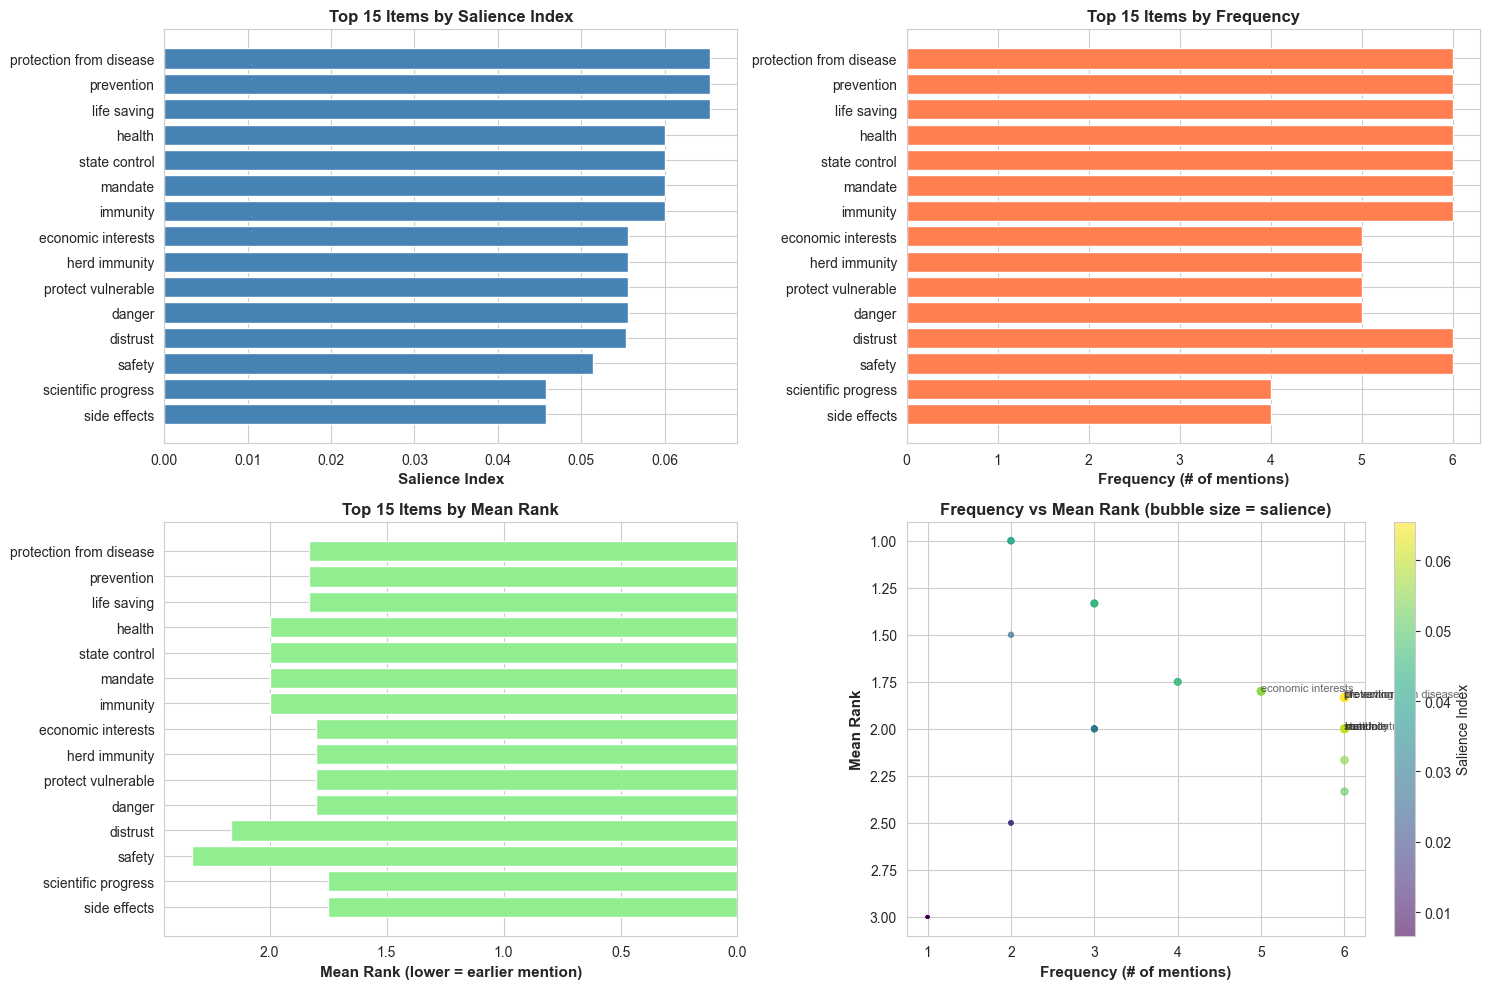

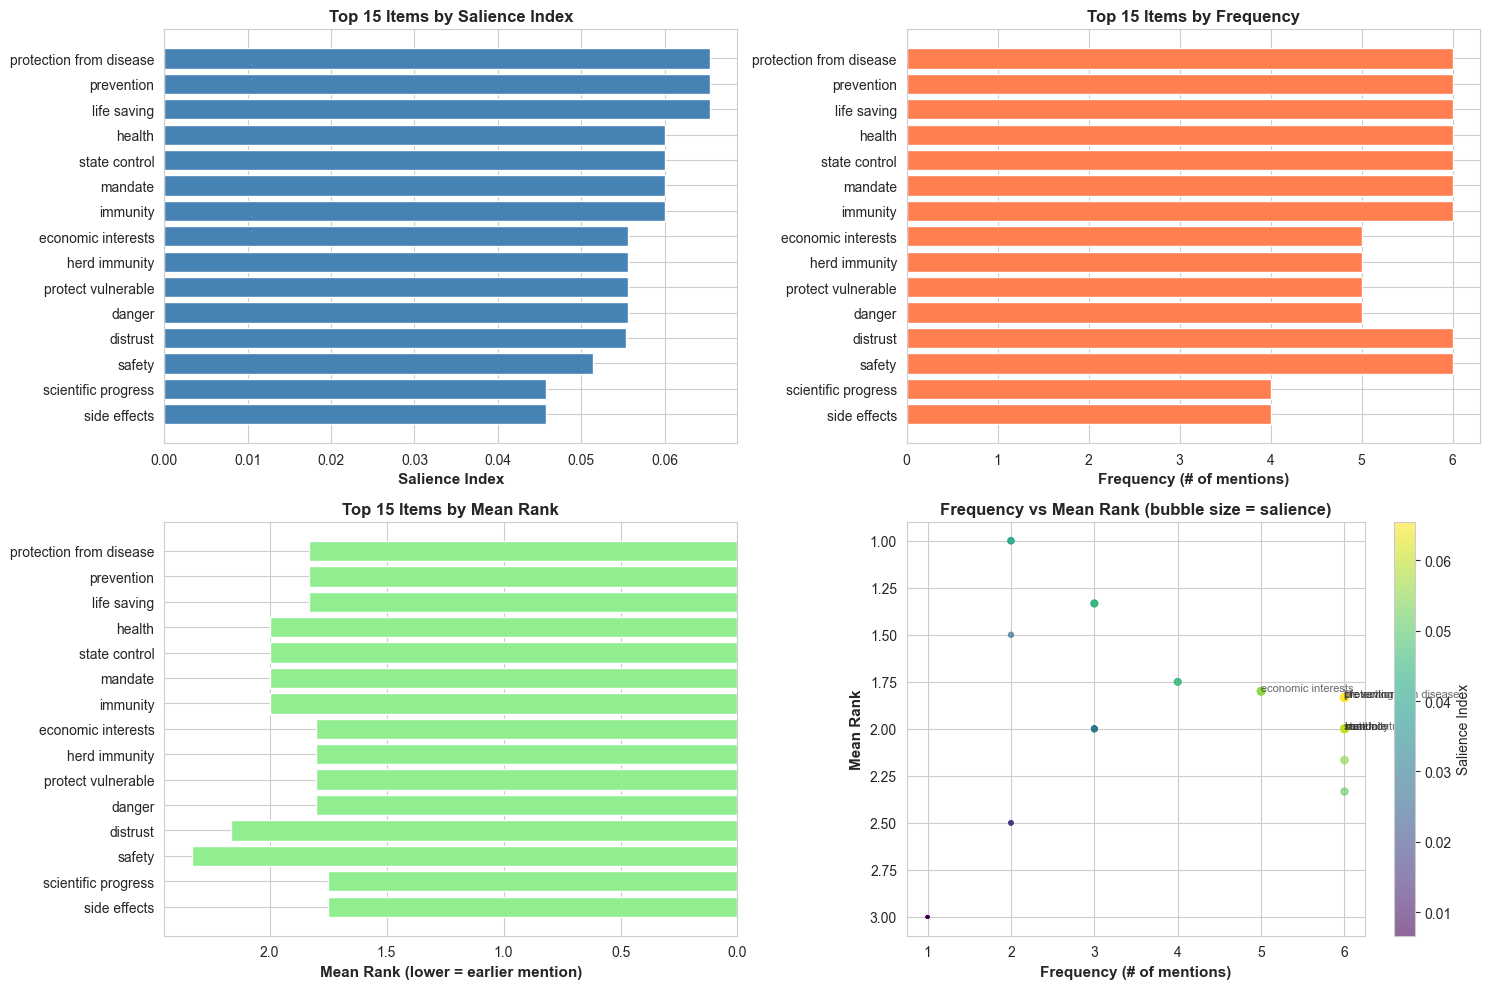

In [23]:
plot_salience_results(salience_df)

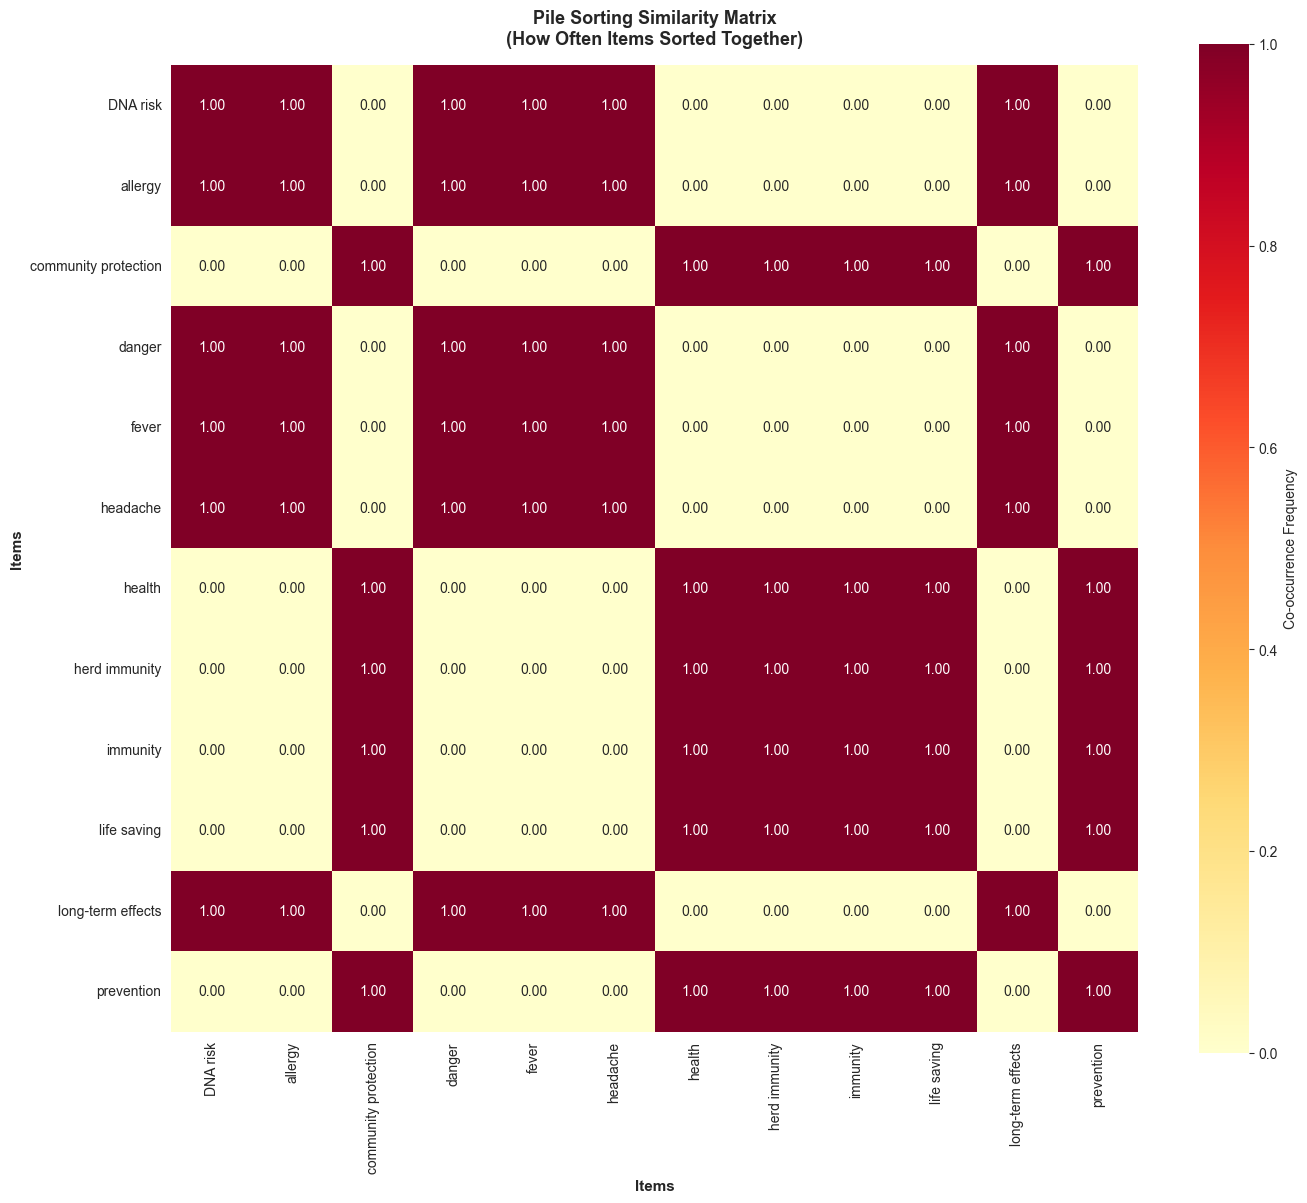

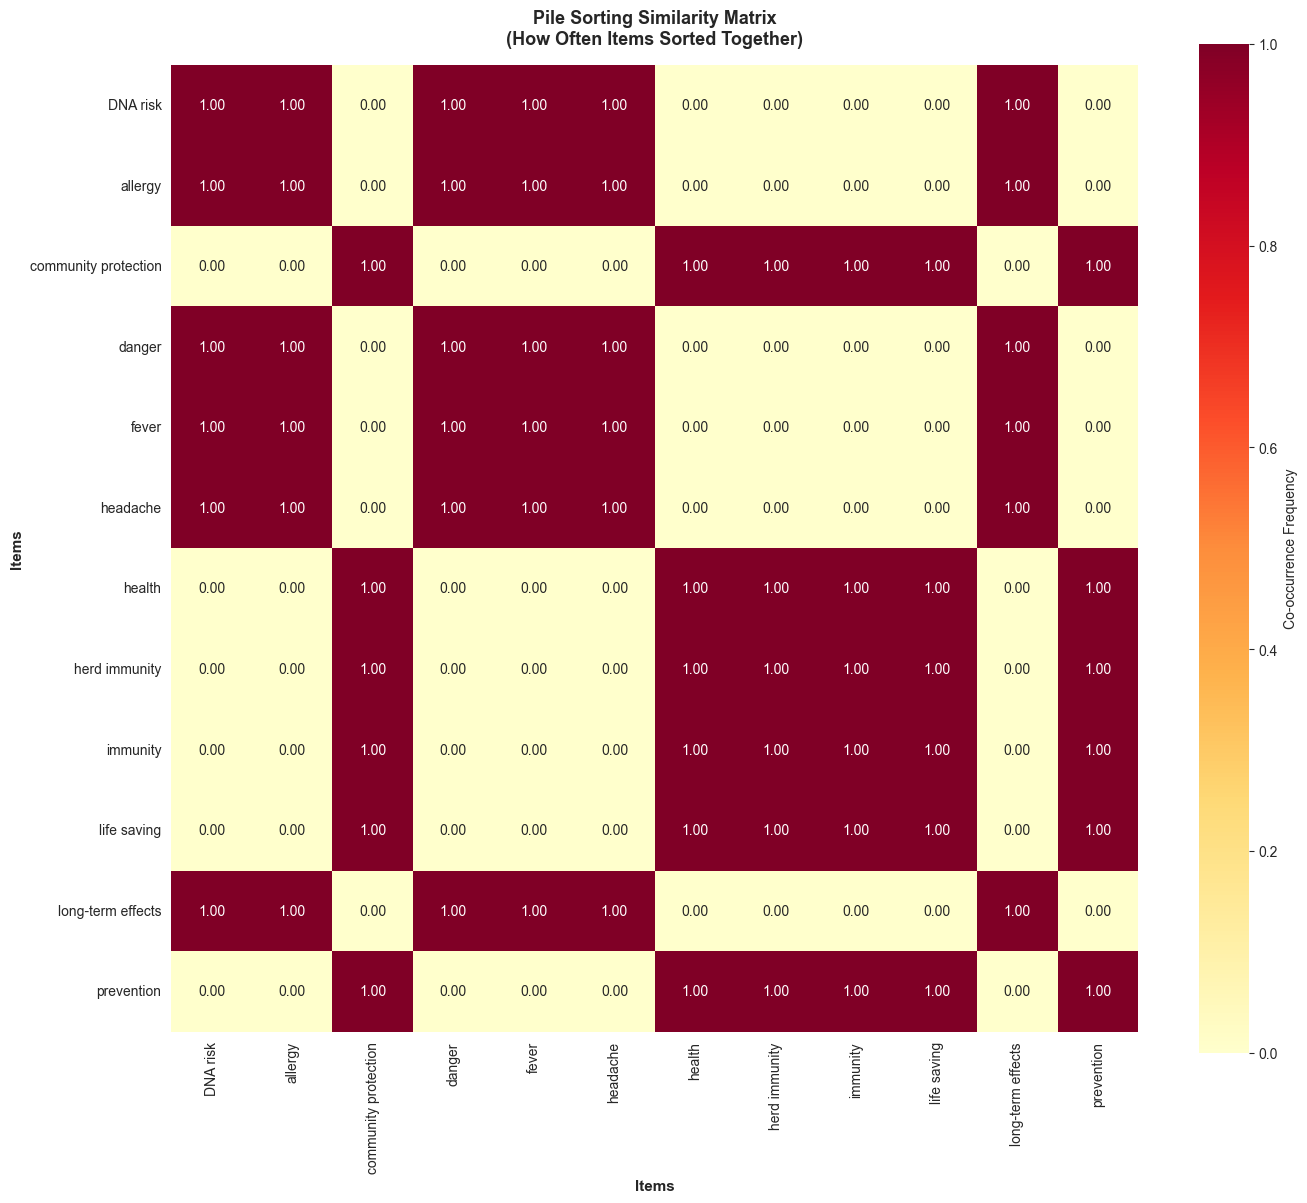

In [24]:
plot_similarity_heatmap(similarity_df, top_n=12)

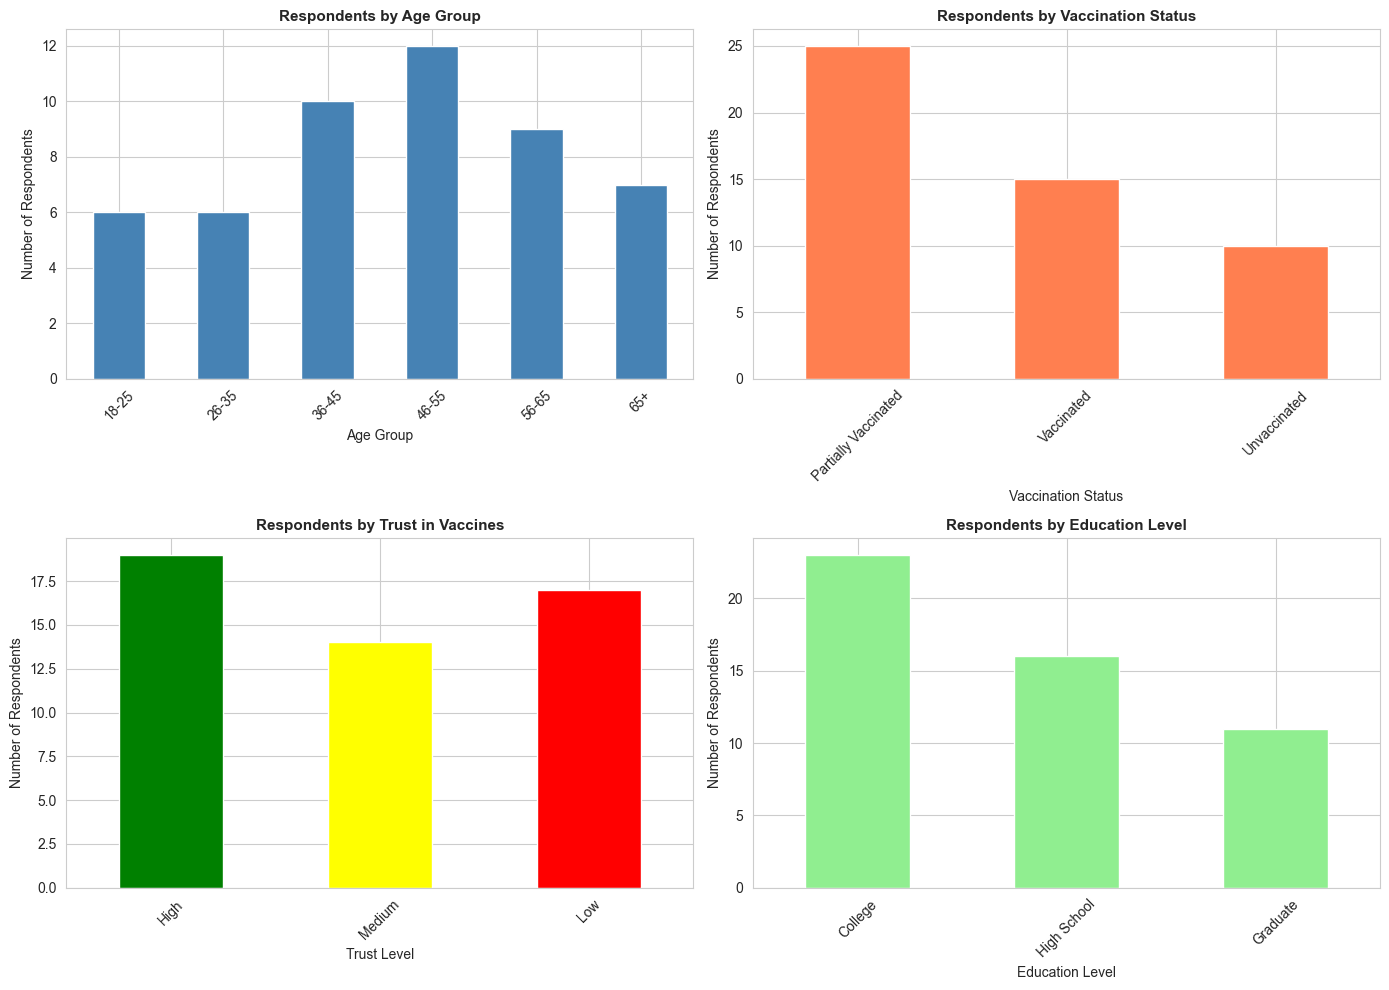

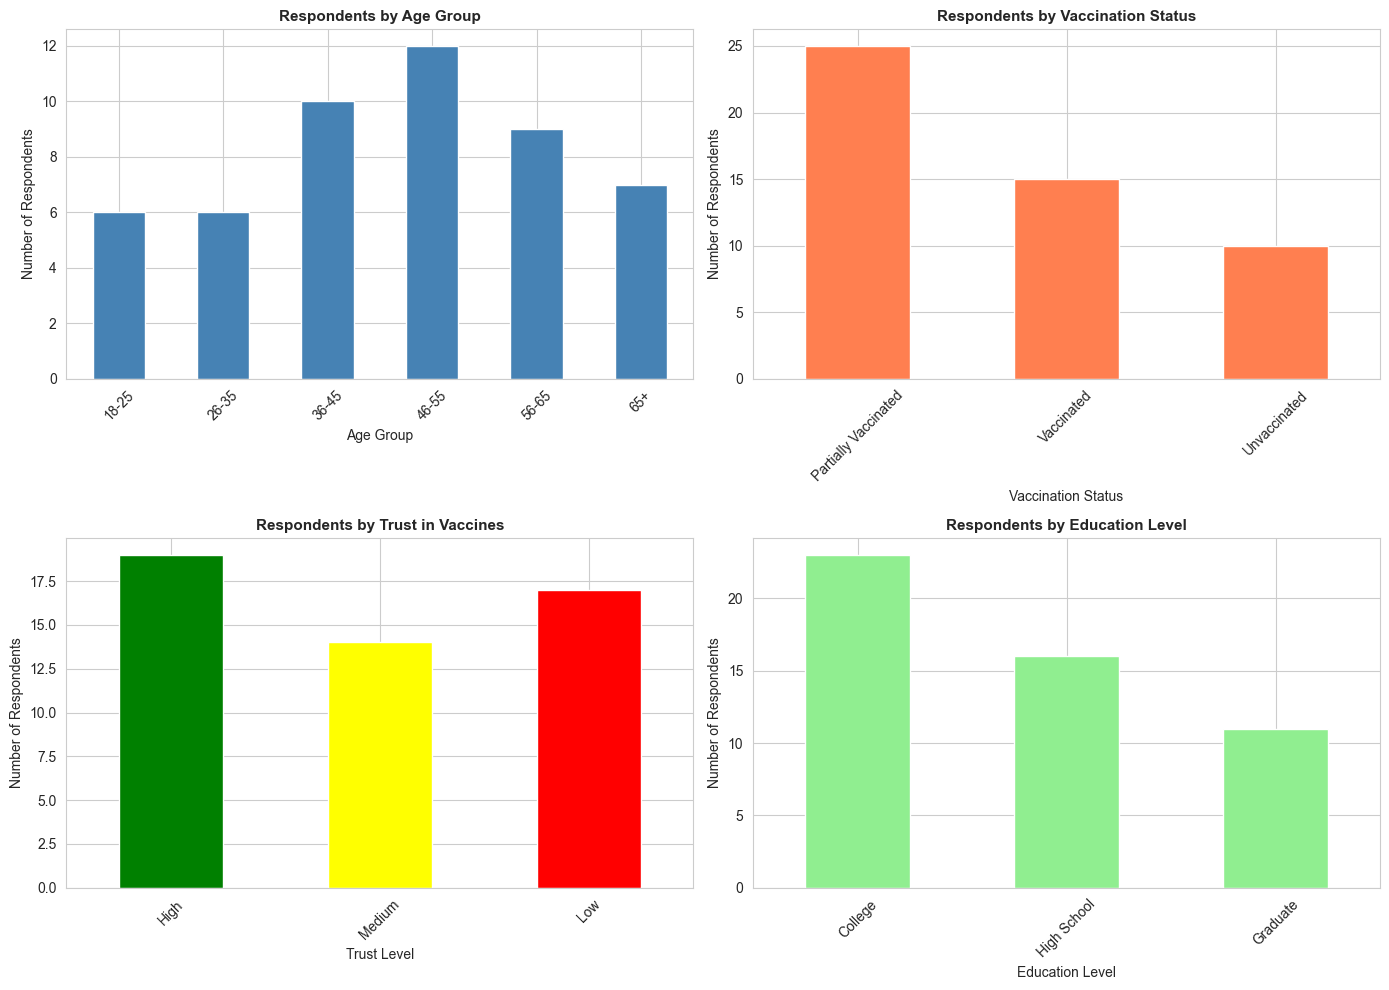

In [25]:
plot_demographic_distributions(metadata_df)

In [28]:
def print_summary_statistics(freelisting_df, metadata_df, salience_df, piles):
    """Print comprehensive summary of analysis"""

    print('\n' + '='*70)
    print('KEY FINDINGS FROM CULTURAL DOMAIN ANALYSIS')
    print('='*70 + '\n')

    print('1. FREE LISTING ANALYSIS:')
    print('-'*70)
    print(f"   - Total unique items mentioned: {len(salience_df)}")
    print(f"   - Average items per respondent: {len(freelisting_df) * 3 / len(freelisting_df):.1f}")
    print(f"   - Most salient item: {salience_df.iloc[0]['item']} (salience: {salience_df.iloc[0]['salience']:.3f})")
    print(f"   - Item mentioned most frequently: {salience_df.iloc[0]['item']} ({salience_df.iloc[0]['frequency']} times)")

    print('\n2. PILE SORTING ANALYSIS:')
    print('-'*70)
    print(f"   - Number of major cultural domains: {len(piles)}")
    for domain, items in piles.items():
        print(f"   - {domain}: {len(items)} items")

    print('\n3. DEMOGRAPHIC PATTERNS:')
    print('-'*70)
    vaccinated = len(metadata_df[metadata_df['vaccination_status'] == 'Vaccinated'])
    unvaccinated = len(metadata_df[metadata_df['vaccination_status'] == 'Unvaccinated'])
    high_trust = len(metadata_df[metadata_df['trust_in_vaccines'] == 'High'])
    low_trust = len(metadata_df[metadata_df['trust_in_vaccines'] == 'Low'])

    print(f"   - Vaccinated: {vaccinated} respondents ({vaccinated/len(metadata_df)*100:.0f}%)")
    print(f"   - Unvaccinated: {unvaccinated} respondents ({unvaccinated/len(metadata_df)*100:.0f}%)")
    print(f"   - High trust in vaccines: {high_trust} respondents ({high_trust/len(metadata_df)*100:.0f}%)")
    print(f"   - Low trust in vaccines: {low_trust} respondents ({low_trust/len(metadata_df)*100:.0f}%)")

    print('\n4. TOP 10 MOST SALIENT ITEMS:')
    print('-'*70)
    for idx, row in salience_df.head(10).iterrows():
        print(f"   {row['item']:.<40} Salience: {row['salience']:>6.3f}  Freq: {row['frequency']:>2d}")


def print_cultural_domains_summary(piles):
    """Print summary of identified cultural domains"""

    print('\n' + '='*70)
    print('IDENTIFIED CULTURAL DOMAINS IN VACCINATION ATTITUDES')
    print('='*70 + '\n')

    for domain_name, items in piles.items():
        print(f"DOMAIN: {domain_name.upper()}")
        print('-'*70)
        print(f"Number of items: {len(items)}")
        print(f"\nItems in this domain:")
        for i, item in enumerate(items, 1):
            print(f"  {i:2d}. {item}")
        print('\n')


In [29]:
print_summary_statistics(freelisting_df, metadata_df, salience_df, piles)
    #print_cultural_domains_summary(piles)
    #export_results(salience_df, similarity_df, metadata_df, piles)


KEY FINDINGS FROM CULTURAL DOMAIN ANALYSIS

1. FREE LISTING ANALYSIS:
----------------------------------------------------------------------
   - Total unique items mentioned: 48
   - Average items per respondent: 3.0
   - Most salient item: protection from disease (salience: 0.065)
   - Item mentioned most frequently: protection from disease (6 times)

2. PILE SORTING ANALYSIS:
----------------------------------------------------------------------
   - Number of major cultural domains: 5
   - Positive Effects: 10 items
   - Risks: 10 items
   - Political Control: 6 items
   - Economic Interests: 7 items
   - Natural Alternatives: 8 items

3. DEMOGRAPHIC PATTERNS:
----------------------------------------------------------------------
   - Vaccinated: 15 respondents (30%)
   - Unvaccinated: 10 respondents (20%)
   - High trust in vaccines: 19 respondents (38%)
   - Low trust in vaccines: 17 respondents (34%)

4. TOP 10 MOST SALIENT ITEMS:
-----------------------------------------------